# Reading in the experiment to analyze for bit error, codebooks, and bulk rna-seq data

In [68]:
analysis_folder = r"E:\E20190920_R0004_3D_Guo"
codebook_file = r"D:\MERFISH\MERlin_Parameters\codebooks\codebook_alex_130gene.csv"
#codebook_file = r"D:\MERFISH\MERlin_Parameters\codebooks\codebook_heart_tissue.csv"
expanded_codebook_file = r"D:\MERFISH\MERlin_Parameters\codebooks\codebook_alex_130gene_expanded.csv"
#expanded_codebook_file = r"D:\MERFISH\MERlin_Parameters\codebooks\codebook_heart_tissue_expanded.csv"
rnaseq_reference = r'D:\MERFISH\Random_Data\U2OS_abundances_qz.rpkm'

In [10]:
import numpy as np
import pandas as pd
import glob
from tqdm.notebook import tqdm
import os
import PIL
from PIL import Image


In [11]:
print("Counting decoded barcodes")
barcode_files = glob.glob(os.path.join(analysis_folder, r"Decode\barcodes\barcode_data_*.h5"))
fovs = len(barcode_files)
raw_count = 0
for file in tqdm(glob.glob(os.path.join(analysis_folder, r"Decode\barcodes\barcode_data_*.h5"))):
    barcodes = pd.read_hdf(file)
    raw_count += len(barcodes)
    
print("Counting filtered barcodes")
filter_count = len(pd.read_csv(os.path.join(analysis_folder, r"ExportBarcodes\barcodes.csv")))

print("FOVS:", fovs)
print(raw_count, raw_count/fovs, filter_count, filter_count/fovs, filter_count/raw_count)

Counting decoded barcodes



Counting filtered barcodes
FOVS: 20
117480598 5874029.9 2561809 128090.45 0.021806230506249212


In [12]:
import pandas
from scipy.linalg import norm
from sklearn.neighbors import NearestNeighbors
from collections import Counter

def process_fov(filename, normcodes):
    barcodes = pandas.read_hdf(filename)
    fov = int(filename.split('_')[-1].split('.')[0])

    #Subset for testing
    #barcodes = barcodes.iloc[1000:1050]

    #Get just the intensity columns for convenience
    intensities = barcodes[[f'intensity_{i}' for i in range(16)]]
    intensities = intensities.rename(columns=lambda x: 'intensity_' + str(int(x.split('_')[1])+1)) 

    #Find nearest
    neighbors = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
    neighbors.fit(normcodes)
    distances, indexes = neighbors.kneighbors(intensities, return_distance=True)

    rows = []
    for i, index in enumerate(indexes):
        barcode = codebook.iloc[index[0]]
        ints = intensities.iloc[i]
        test = pandas.concat([barcode, ints], axis=0)
        rows.append(test)

    df = pandas.DataFrame(rows)
    df['fov'] = fov
    
    return df

def error_stats(data):
    c = Counter(data.filter(like='bit').sum(axis=1))
    total = sum(c.values())
    return pandas.Series([total, c[4] / total, c[5] / total, c[3] / total], index=["Barcodes", "Correct", "0->1 error", "1->0 error"])
    

In [13]:
#L2 normalize codebook
import pandas

codebook = pandas.read_csv(expanded_codebook_file)
codes = codebook.filter(like='bit')
normcodes = codes.apply(lambda row: row / norm(row), axis=1)

files = glob.glob(os.path.join(analysis_folder, r"AdaptiveFilterBarcodes\barcodes\barcode_data_*.h5"))

dfs = [process_fov(filename, normcodes) for filename in tqdm(files)]
df = pandas.concat(dfs)

# Error Rate Data

In [14]:
#This will give the 0 -> 1 and 1 -> 0 error rates
print(error_stats(df))

Barcodes      2.565610e+06
Correct       8.334992e-01
0->1 error    4.145057e-02
1->0 error    1.250502e-01
dtype: float64


In [15]:
ones2zeros = []
zeros2ones = []
for gene in df['name'].unique():
    x = df[df['name'] == gene]
    z = codebook[codebook['id'] == gene]
    i = z.columns[(z == 1).iloc[0]]
    o2z = pandas.DataFrame((len(x) - x[i].sum()) / len(x)).T
    z2o = pandas.DataFrame(x[x.filter(like='bit').columns.difference(i)].sum() / len(x)).T
    ones2zeros.append(o2z)
    zeros2ones.append(z2o)

The following cell will export the bit errors to an excel sheet; change the name of the excel sheet if wanted in the ExcelWriter function. It will also give error visualizations

In [16]:
import seaborn as sns
import math
import matplotlib.pyplot as plt

def meltdata(df):
    data = pandas.concat(df, axis=0)
    data = data.rename(columns=lambda x: int(x.strip('bit')))
    data = data.melt(value_vars=data.columns, var_name='Bit', value_name='Error rate')
    return data

d = meltdata(ones2zeros)
d['Error type'] = '1 -> 0'
d2 = meltdata(zeros2ones)
d2['Error type'] = '0 -> 1'
data = pandas.concat([d, d2])

ax = sns.catplot(x="Bit", y="Error rate", row="Error type", data=data, kind="bar", height=2, aspect=3,
    capsize=0.2, color='dodgerblue', order=sorted(data["Bit"].unique()), sharey=False, sharex=False)
ax.savefig(os.path.join(analysis_folder, "biterror.png"), dpi=300)
average = {}
average2 = {}
for index, i in d.iterrows():
    average[(i["Bit"])] = []
for index, i in d.iterrows():
    average.get(i["Bit"]).append(i["Error rate"])
for i in average:
    thelist = average.get(i)
    countj = 0
    runningj = 0
    for j in thelist:
        if math.isnan(j) == False:
            runningj += j
            countj += 1
    if countj > 0:
        average2[i] = float(runningj/countj)
average2 = pd.DataFrame(average2.items())
average2.columns = ["Bit", "Error"]
print(average2)

average01 = {}
for index, i in d2.iterrows():
    average01[(i["Bit"])] = []
for index, i in d2.iterrows():
    average01.get(i["Bit"]).append(i["Error rate"])
for i in average01:
    thelist = average01.get(i)
    countj = 0
    runningj = 0
    for j in thelist:
        if math.isnan(j) == False:
            runningj += j
            countj += 1
    if countj > 0:
        average01[i] = float(runningj/countj)
average01 = pd.DataFrame(average01.items())
average01.columns = ["Bit", "Error"]
print(average01)

with pd.ExcelWriter('3d_4.xlsx') as writer:  
    average2.to_excel(writer, sheet_name='Sheet_name_1')
    average01.to_excel(writer, sheet_name='Sheet_name_2')

C:\Users\amonell\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


    Bit     Error
0     1  0.026885
1    10  0.047689
2    11  0.030786
3    12  0.029303
4    13  0.041353
5    14  0.058734
6    15  0.023929
7    16  0.067588
8     2  0.034179
9     3  0.037227
10    4  0.028539
11    5  0.027299
12    6  0.026450
13    7  0.030243
14    8  0.021828
15    9  0.031652
    Bit     Error
0     1  0.004508
1    10  0.006333
2    11  0.006471
3    12  0.007299
4    13  0.004987
5    14  0.007056
6    15  0.005551
7    16  0.008222
8     2  0.006581
9     3  0.004199
10    4  0.006819
11    5  0.009722
12    6  0.010453
13    7  0.005453
14    8  0.005747
15    9  0.005846


# Finding the error rate per FOV

In [17]:
fovs = df.groupby('fov').apply(error_stats)
fovs['FOV'] = fovs.index
fovs.columns = ['Count', 'Correct', '0 -> 1', '1 -> 0', 'FOV']
fovs = fovs.melt(id_vars='FOV', value_vars=['0 -> 1', '1 -> 0'], var_name = 'Error type', value_name='Error rate')

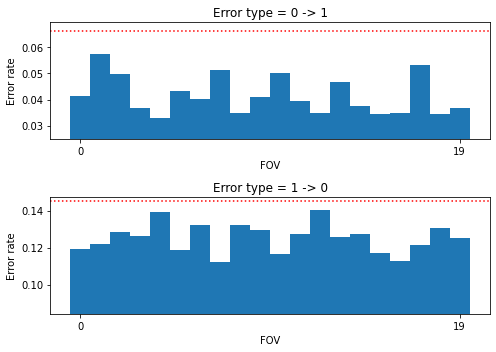

In [18]:
def fovplot(d, ax):
    q1 = d['Error rate'].quantile(0.25)
    q3 = d['Error rate'].quantile(0.75)
    outlier = q3 + 1.5 * (q3 - q1)
    outlier
    ax.bar(d['FOV'], d['Error rate'], width=1)
    ax.axhline(outlier, color='red', linestyle=':')
    for i, row in d[d['Error rate'] >= outlier].iterrows():
        ax.annotate(row['FOV'], (row['FOV'], row['Error rate']), ha='center', color='orangered', weight='heavy')
    #ax.set_xlim(left=0, right=d['FOV'].max())
    ax.set_xticks(list(range(0, d['FOV'].max(), 25)) + [d['FOV'].max()])
    ax.set_xlabel("FOV")
    ax.set_ylabel("Error rate")
    ax.set_ylim(bottom=d['Error rate'].min()*0.75)
        
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7,5))
fovplot(fovs[fovs['Error type'] == '0 -> 1'], ax[0])
fovplot(fovs[fovs['Error type'] == '1 -> 0'], ax[1])
ax[0].set_title("Error type = 0 -> 1")
ax[1].set_title("Error type = 1 -> 0")
plt.tight_layout()
plt.savefig(os.path.join(analysis_folder, "foverror.png"), dpi=300)

# Gene abundance Correlations

Can add gene names in using if you want to see their normalized counts

In [19]:
import math
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def plot_correlation(xcounts, ycounts, xlabel, ylabel, outfile, omit=[]):
    set1 = set(xcounts.keys())
    set2 = set(ycounts.keys())
    genes_to_consider = list(set1.intersection(set2))
    x = [xcounts[gene] for gene in genes_to_consider if gene not in omit]
    y = [ycounts[gene] for gene in genes_to_consider if gene not in omit]
    using = []
    #using.append("PRPF8")

    for gene in genes_to_consider: 
        if gene not in omit and gene in using:
            print(gene, (10**ycounts[gene]))
    num = []
    count = 0
    for gene in genes_to_consider:
    #    if gene not in omit:
    #        count += 1
            #print(gene)
    #        if gene == "EGFR":
    #            print(10**y[count])
            if gene not in omit:
                num.append(gene) 
    
    corr, pval = pearsonr(x,y)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.figure(figsize=(7,5))
    plt.plot(x,p(x),"r--")

    plt.scatter(x, y)
    plt.title("Pearson = %.3f" %corr)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    for i, txt in enumerate(num):
        plt.annotate(txt, (x[i], y[i]), size=8, textcoords="offset points")
    #plt.savefig(os.path.join(analysis_folder, outfile), dpi=300)
    

Loading the merfish counts from our experiments, whichever barcode_counts.npy file that is desired

In [56]:
import os
import numpy as np
import pandas as pd

def load_merfish_counts(filename, codebook):
    gene_counts = np.load(filename)
    ordered_genes = list(codebook['name'])
    abundances = {}
    for i, gene in enumerate(ordered_genes):
        abundances[gene] = np.log10(gene_counts[i]+1)
    return abundances

#Load MERFISH counts
codebook = pd.read_csv(codebook_file)
#merfish_counts = load_merfish_counts(os.path.join(analysis_folder, r"PlotPerformance\filterplots\FilteredBarcodesMetadata\barcode_counts.npy"), codebook)
merfish_counts2 = load_merfish_counts(r"D:\MERFISH\E20190920_R0004\MERlin_Analysis\E20190920_R0004_v4\PlotPerformance\filterplots\FilteredBarcodesMetadata\barcode_counts.npy",codebook)
#merfish_counts = load_merfish_counts(r"D:\MERFISH\MERlin_Analysis\E20201123_R0040\PlotPerformance\filterplots\FilteredBarcodesMetadata\barcode_counts.npy",codebook)
merfish_counts = load_merfish_counts(r"E:\E20190920_R0004_3D_Guo\PlotPerformance\filterplots\FilteredBarcodesMetadata\barcode_counts.npy",codebook)
#merfish_counts = load_merfish_counts(r"C:\Users\amonell\Documents\barcode_counts.npy",codebook)

Loading in the Moffitt PNAS rna-seq counts (old version)

In [21]:
pnas_rna = pd.read_csv(r'D:\MERFISH\Random_Data\SRR987281.fpkm', sep=',')
pnas_rna2 = pd.read_csv(r'D:\MERFISH\Random_Data\SRR987282.fpkm', sep=',')
pnas_rna3 = pd.read_csv(r'D:\MERFISH\Random_Data\SRR987283.fpkm', sep=',')
pnas1 = dict(zip(pnas_rna['gene_id'], pnas_rna['FPKM']))
pnas2 = dict(zip(pnas_rna2['gene_id'], pnas_rna2['FPKM']))
pnas3 = dict(zip(pnas_rna3['gene_id'], pnas_rna3['FPKM']))
setpnas1 = set(pnas1.keys())
setpnas2 = set(pnas2.keys())
setpnas3 = set(pnas3.keys())
genes_to_consider2 = setpnas1.intersection(setpnas2)
genes_to_consider3 = list(genes_to_consider2.intersection(setpnas3))
fin_dict = {}
for gene in genes_to_consider3:
    avg = (pnas1[gene] + pnas2[gene] + pnas3[gene])/3.0
    fin_dict[gene] = np.log10(avg+1)
    #fin_dict[gene] = avg + 1

Loading in the Moffitt PNAS rna-seq counts (new version)

In [22]:
pnas_rnaseq = pd.read_csv(r'D:\PNAS2016Data\data_for_release\file_io\PNAS2016_RNAseq_FPKM.csv', sep = ',')
pnas_rnaseq_fin = dict(zip(pnas_rnaseq['geneName'], pnas_rnaseq['FPKM']))
setprna = set(pnas_rnaseq_fin.keys())
genes_to_prna = list(setprna)
pnas_dict_rna = {}
for gene in genes_to_prna:
    pnas_dict_rna[gene] = np.log10(pnas_rnaseq_fin[gene]+1)

threshold of 0 gives all genes, higher threshold closer to the total number of genes gives the lower count genes.

In [23]:
def getlowcounts(xcounts, ycounts):
    omit = []
    set1 = set(xcounts.keys())
    set2 = set(ycounts.keys())
    genes_to_consider = list(set1.intersection(set2))
    #print(genes_to_consider)
    #genes_to_consider = zcounts
    x = [xcounts[gene] for gene in genes_to_consider if gene not in omit]
    y = [ycounts[gene] for gene in genes_to_consider if gene not in omit]
    z = [math.sqrt(y[z]**2 + x[z]**2) for z in range(len(x))]
    threshold = 0
    temp = []
    while len(temp) < threshold:
        minval = min(z)
        minindex = z.index(minval)
        temp.append(genes_to_consider[minindex])
        del z[minindex]
        del genes_to_consider[minindex]
    return temp

threshold of total gene number gives all genes, lower threshold closer to 0 gives higher count genes.

In [24]:
def gethighcounts(xcounts, ycounts):
    omit = []
    set1 = set(xcounts.keys())
    set2 = set(ycounts.keys())
    genes_to_consider = list(set1.intersection(set2))
    #genes_to_consider = zcounts
    x = [xcounts[gene] for gene in genes_to_consider if gene not in omit]
    y = [ycounts[gene] for gene in genes_to_consider if gene not in omit]
    z = [math.sqrt(y[z]**2 + x[z]**2) for z in range(len(x))]
    threshold = 130
    temp = []
    while len(temp) < threshold:
        minval = min(z)
        minindex = z.index(minval)
        temp.append(genes_to_consider[minindex])
        del z[minindex]
        del genes_to_consider[minindex]
    t = [gene for gene in genes_to_consider if gene not in temp]
    #t.append('MALAT1')
    return t
        

Loading in our rna-seq values, PNAS MERFISH Counts, and correlating.  Can omit high count or low count genes if wanted.

C:\Users\amonell\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


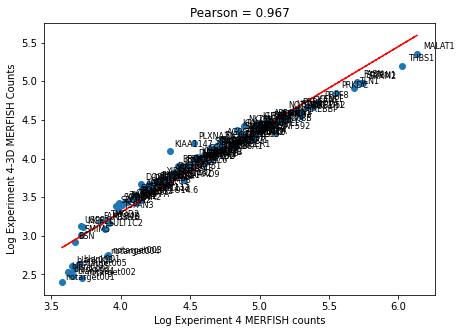

In [57]:
#Load RNA-seq rpkm values
col = pd.read_csv(r'D:\MERFISH\Random_Data\U2OS_abundances_qz.rpkm', sep='\t')
#Take the average rpkm of both replicates
col['mean'] = col[['bam.RQZ90.nodup.bam','bam.RQZ91.nodup.bam']].mean(axis=1)
#Log transform the data and turn it into a dictionary
rnaseq_counts = dict(zip(col['Geneid'], np.log10(col['mean']+1)))

new_pnas = pd.read_csv(r'D:\MERFISH\Random_Data\PNAS2016_MERFISH_counts_new.csv', sep=',', header = None)
new_pnas.columns = ['name', 'counts'] 

new_pnas_counts = dict(zip(new_pnas['name'], np.log10(new_pnas['counts']+1)))

plot_correlation(xcounts=merfish_counts2, 
                   ycounts=merfish_counts, 
                   xlabel='Log Experiment 4 MERFISH counts', 
                   ylabel='Log Experiment 4-3D MERFISH Counts', 
                   outfile='RNASeq_corr.png',
                   omit=[])#gethighcounts(xer, yer))

# How a gene behaves in an individual experiment after cellpose and edge cell removing

In [28]:
#Start here
import glob
import os
import pandas as pd
import numpy as np
import PIL
from PIL import Image


#mask_folder = r'D:\MERFISH\Segmentation\E20190919_R0003\cy3_320diameter_slice30'
mask_folder = r'D:\MERFISH\Segmentation\E20190920_R0004\cyto_fullsize_320diameter'
#mask_folder = r'D:\MERFISH\Segmentation\E20190930_R0006\cy3_320diameter_slice30'
#mask_folder = r'D:\MERFISH\Segmentation\E20201106_R0034\cyto_fullsize_320diameter'
#mask_folder = r'D:\MERFISH\Segmentation\E20201222_R0049_S1\cyto_fullsize_320diameter'
#mask_folder = r'D:\MERFISH\Segmentation\E20201123_R0040\cyto_fullsize'
#mask_folder = r'D:\MERFISH\Segmentation\E20200310_R0022\cy3_320diameter_slice30'

#read in segmentation mask
edgecells = set()
for fov, filename in enumerate(sorted(glob.glob(os.path.join(mask_folder, '*_cp_masks.png')))):
    mask = np.asarray(PIL.Image.open(filename))
    edgecells.update(10000*fov + np.unique(np.concatenate([mask[:,0], mask[:,-1], mask[0,:], mask[-1,:]])))
    
    
#table = pd.read_csv("D:\MERFISH\MERlin_Analysis\E20201106_R0034\single_cell_raw_counts.csv")
#table = pd.read_csv("D:\MERFISH\Archived_Experiments\E20190919_R0003\MERlin_Analysis\E20190919_R0003_v2\single_cell_raw_counts.csv")
#table = pd.read_csv("D:\MERFISH\E20190920_R0004\MERlin_Analysis\E20190920_R0004_v4\single_cell_analysis_cyto_fullsize_320diameter\single_cell_raw_counts.csv")
#table = pd.read_csv("D:\MERFISH\Archived_Experiments\E20190930_R0006\MERlin_Analysis\E20190930_R0006\single_cell_raw_counts.csv")
#table = pd.read_csv("D:\MERFISH\MERlin_Analysis\E20201106_R0035\single_cell_raw_counts.csv")
#table = pd.read_csv("D:\MERFISH\MERlin_Analysis\E20201223_R0049_S2\single_cell_analysis_cyto_fullsize_320diameter\single_cell_raw_counts.csv")
#table = pd.read_csv("D:\MERFISH\MERlin_Analysis\E20201222_R0049_S1\single_cell_raw_counts.csv")
#table = pd.read_csv("D:\MERFISH\MERlin_Analysis\E20201123_R0040\single_cell_raw_counts.csv")
#table = pd.read_csv("D:\MERFISH\E20200310_R0022\MERlin_Analysis\E20200310_R0022\single_cell_analysis_cy3_320diameter_slice30\single_cell_raw_counts.csv")


table = pd.read_csv("E:\E20190920_R0004_3D_Guo\single_cell_raw_counts.csv")
#filter out the cells on the edges
table = table[~table['cell_id'].isin(edgecells)] 
for index, row in table.iterrows():
    total = sum(row[1:])
    for i in range(len(row)):
        if i != 0:
            row[i] = float(row[i]/total)*1000000
        

5474016
359
15247.955431754875
4599.4408432584305
0.30164311955423156


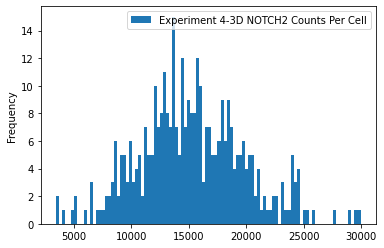

In [30]:
import statistics
import numpy as np
import pandas as pd
import matplotlib
#Get the specific gene from the table and perform calculations
prp_vals = table["NOTCH2"].to_list()
average_per_cell = sum(prp_vals)/len(prp_vals)
num_cells = len(prp_vals)
std_dev_cell = statistics.stdev(prp_vals)

#The total number of gene counts across all cells
print(sum(prp_vals))
#The total number of cells after filtering in the experiment
print(num_cells)
#The average number of gene counts per cell
print(average_per_cell)
#The standard deviation of the number of gene counts per cell
print(std_dev_cell)
#The standard deviation of the number of gene counts per cell divided by the average number of gene counts per cell
print(std_dev_cell/average_per_cell)

histo = pd.DataFrame({'Experiment 4-3D NOTCH2 Counts Per Cell': table["NOTCH2"].to_list()})
plot = histo.plot.hist(bins = 100)
fig = plot.get_figure()

Assorted gene metrics

In [31]:
genetypes = table.columns[1:]
prpvals_list = []
average_per_cell_list = []
num_cells_list = []
std_list = []
for i in genetypes:
    prp_vals = table[i].to_list()
    average_per_cell = sum(prp_vals)/len(prp_vals)
    num_cells = len(prp_vals)
    std_dev_cell = statistics.stdev(prp_vals)
    prpvals_list.append(sum(prp_vals))
    average_per_cell_list.append(average_per_cell)
    num_cells_list.append(num_cells)
    std_list.append(std_dev_cell)
    

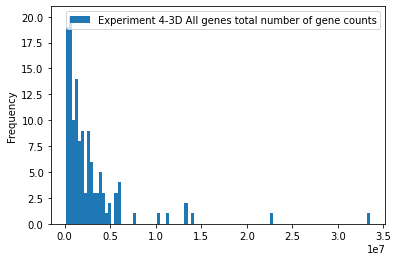

In [32]:
plot = pd.DataFrame({'Experiment 4-3D All genes total number of gene counts': prpvals_list}).plot.hist(bins = 100)
fig = plot.get_figure()


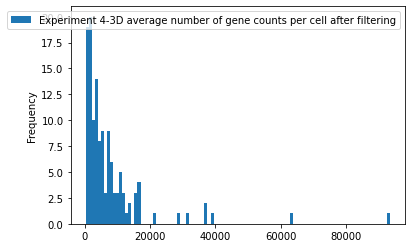

In [33]:
plot = pd.DataFrame({'Experiment 4-3D average number of gene counts per cell after filtering': average_per_cell_list}).plot.hist(bins = 100)
fig = plot.get_figure()

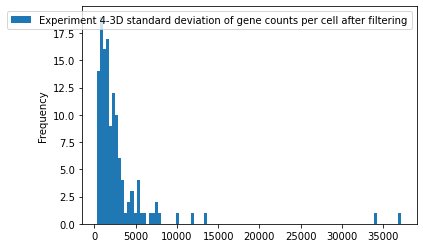

In [34]:
plot = pd.DataFrame({'Experiment 4-3D standard deviation of gene counts per cell after filtering': std_list}).plot.hist(bins = 100)
fig = plot.get_figure()

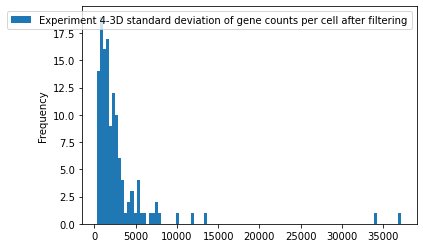

In [35]:
plot = pd.DataFrame({'Experiment 4-3D standard deviation of gene counts per cell after filtering': std_list}).plot.hist(bins = 100)
fig = plot.get_figure()

# Viewing all experiments at once

In [36]:

mask_folders = ['D:\MERFISH\Segmentation\E20190920_R0004\cyto_fullsize_320diameter', 'D:\MERFISH\Segmentation\E20190920_R0004\cyto_fullsize_320diameter']
raw_counts_folders = ["D:\MERFISH\E20190920_R0004\MERlin_Analysis\E20190920_R0004_v4\single_cell_analysis_cyto_fullsize_320diameter\single_cell_raw_counts.csv", "E:\E20190920_R0004_3D_Guo\single_cell_raw_counts.csv"]
#mask_folders = ['D:\MERFISH\Segmentation\E20190919_R0003\cy3_320diameter_slice30','D:\MERFISH\Segmentation\E20190920_R0004\cyto_fullsize_320diameter', 'D:\MERFISH\Segmentation\E20190930_R0006\cy3_320diameter_slice30', 'D:\MERFISH\Segmentation\E20201106_R0034\cyto_fullsize_320diameter', 'D:\MERFISH\Segmentation\E20201222_R0049_S1\cyto_fullsize_320diameter', 'D:\MERFISH\Segmentation\E20201123_R0040\cyto_fullsize', 'D:\MERFISH\Segmentation\E20200310_R0022\cy3_320diameter_slice30', 'D:\MERFISH\Segmentation\E20201223_R0049_S2\cyto_fullsize_320diameter']
#raw_counts_folders = ["D:\MERFISH\Archived_Experiments\E20190919_R0003\MERlin_Analysis\E20190919_R0003_v2\single_cell_raw_counts.csv", "D:\MERFISH\E20190920_R0004\MERlin_Analysis\E20190920_R0004_v4\single_cell_analysis_cyto_fullsize_320diameter\single_cell_raw_counts.csv", "D:\MERFISH\Archived_Experiments\E20190930_R0006\MERlin_Analysis\E20190930_R0006\single_cell_raw_counts.csv", "D:\MERFISH\MERlin_Analysis\E20201106_R0034\single_cell_raw_counts.csv", "D:\MERFISH\MERlin_Analysis\E20201222_R0049_S1\single_cell_raw_counts.csv", "D:\MERFISH\MERlin_Analysis\E20201123_R0040\single_cell_raw_counts.csv", "D:\MERFISH\E20200310_R0022\MERlin_Analysis\E20200310_R0022\single_cell_analysis_cy3_320diameter_slice30\single_cell_raw_counts.csv", "D:\MERFISH\MERlin_Analysis\E20201223_R0049_S2\single_cell_analysis_cyto_fullsize_320diameter\single_cell_raw_counts.csv"]

In [37]:
#highlyexpressed = ['SPTBN1', 'COL5A1', 'HERC2', 'FASN', 'ANKRD52', 'MALAT1', 'PRKDC', 'FAM208B', 'USP9X', 'UBR5', 'TPR', 'LRP1', 'PLXNA1', 'CHST3', 'FAF2', 'PRPF8', 'CENPF', 'TLN1', 'AFF4', 'THBS1', 'DYNC1H1', 'ZNF592', 'CREBBP', 'PRRC2B', 'USP34', 'CKAP5', 'SRRM2', 'CBX5', 'FBN2', 'NOTCH2']
#lowlyexpressed = ['TMOD2', 'USP8', 'SMIM5', 'FAM184B', 'RBM20', 'CEMIP', 'BSN', 'MCF2L', 'SLC9A2', 'XKR5', 'SAMD12', 'SULT1C2', 'TSPAN3', 'NHSL2', 'THSD4', 'RP4-671O14.6', 'SCUBE3', 'PAPPA', 'C14orf132', 'AGO3', 'SOD2', 'SKP1', 'RNF152', 'KIAA1462', 'XDH', 'SLC35B4', 'DOPEY1', 'DSEL', 'CNR2', 'RAD51D']
counts_sum_per_gene_all_cells = []
gene_average_counts_per_cell = []
std_deviation_per_gene = []
divided_per_gene = []
num_cells_exp = []
#order = ['Exp 3', 'Exp 4', 'Exp 6', 'Exp 34', 'Exp 49_S1', 'Exp 40', 'Exp 22', 'Exp 49_S2']
order = ['Exp 4', 'Exp 4-3D']
for i in range(len(mask_folders)):
    mask_folder = mask_folders[i]
    table = pd.read_csv(raw_counts_folders[i])
    
    edgecells = set()
    for fov, filename in enumerate(sorted(glob.glob(os.path.join(mask_folder, '*_cp_masks.png')))):
        mask = np.asarray(PIL.Image.open(filename))
        edgecells.update(10000*fov + np.unique(np.concatenate([mask[:,0], mask[:,-1], mask[0,:], mask[-1,:]])))
    
    table.head()
    table = table[~table['cell_id'].isin(edgecells)] 
    for index, row in table.iterrows():
        total = sum(row[1:])
        for i in range(len(row)):
            if i != 0:
                row[i] = float(row[i]/total)*1000000
        
    prpvals_list = []
    average_per_cell_list = []
    num_cells_list = []
    std_list = []
    divided_list = []
    for i in genetypes:
    #for i in genetypes:
        prp_vals = table[i].to_list()
        average_per_cell = sum(prp_vals)/len(prp_vals)
        num_cells = len(prp_vals)
        std_dev_cell = statistics.stdev(prp_vals)
        prpvals_list.append(sum(prp_vals))
        average_per_cell_list.append(average_per_cell)
        num_cells_list.append(num_cells)
        std_list.append(std_dev_cell)
        divided_list.append(std_dev_cell/average_per_cell)
    counts_sum_per_gene_all_cells.append(np.mean(prpvals_list))
    gene_average_counts_per_cell.append(np.mean(average_per_cell_list))
    std_deviation_per_gene.append(np.mean(std_list))
    divided_per_gene.append(np.mean(divided_list))
    num_cells_exp.append(np.mean(num_cells))

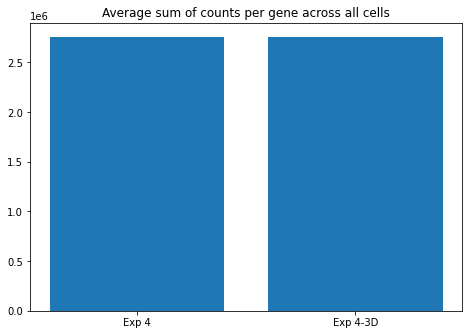

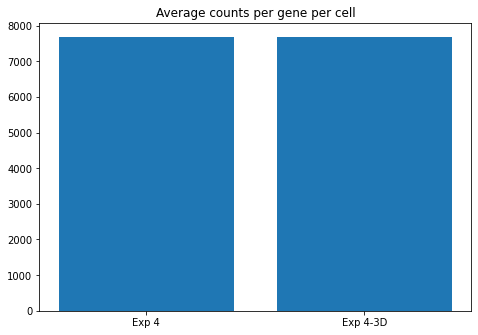

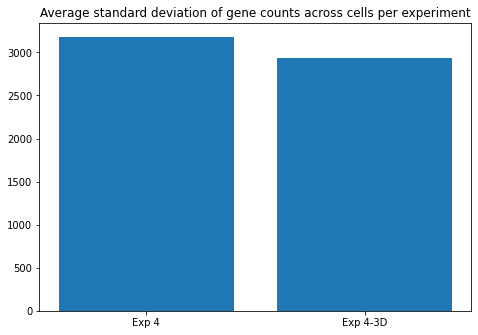

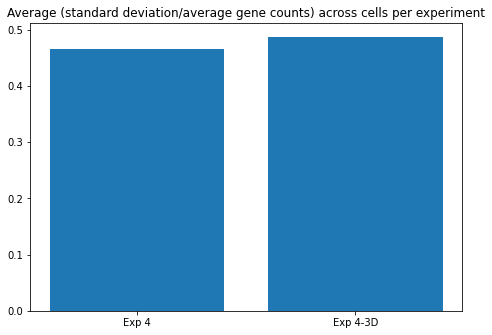

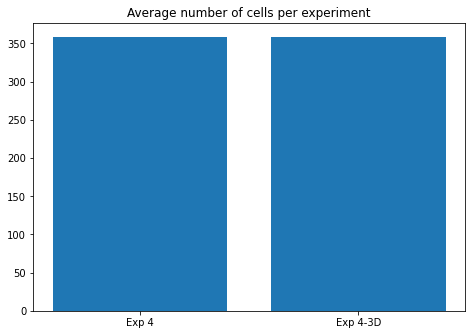

In [38]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(order,counts_sum_per_gene_all_cells)
plt.title('Average sum of counts per gene across all cells')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(order,gene_average_counts_per_cell)
plt.title('Average counts per gene per cell')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(order,std_deviation_per_gene)
plt.title('Average standard deviation of gene counts across cells per experiment')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(order,divided_per_gene)
plt.title('Average (standard deviation/average gene counts) across cells per experiment')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(order,num_cells_exp)
plt.title('Average number of cells per experiment')
plt.show()

# Running Cellpose Correlations

In [39]:
highlyexpressed = ['SPTBN1', 'COL5A1', 'HERC2', 'FASN', 'ANKRD52', 'MALAT1', 'PRKDC', 'FAM208B', 'USP9X', 'UBR5', 'TPR', 'LRP1', 'PLXNA1', 'CHST3', 'FAF2', 'PRPF8', 'CENPF', 'TLN1', 'AFF4', 'THBS1', 'DYNC1H1', 'ZNF592', 'CREBBP', 'PRRC2B', 'USP34', 'CKAP5', 'SRRM2', 'CBX5', 'FBN2', 'NOTCH2']
lowlyexpressed = ['TMOD2', 'USP8', 'SMIM5', 'FAM184B', 'RBM20', 'CEMIP', 'BSN', 'MCF2L', 'SLC9A2', 'XKR5', 'SAMD12', 'SULT1C2', 'TSPAN3', 'NHSL2', 'THSD4', 'RP4-671O14.6', 'SCUBE3', 'PAPPA', 'C14orf132', 'AGO3', 'SOD2', 'SKP1', 'RNF152', 'KIAA1462', 'XDH', 'SLC35B4', 'DOPEY1', 'DSEL', 'CNR2', 'RAD51D']
counts_sum_per_gene_all_cells = []
gene_average_counts_per_cell = []
std_deviation_per_gene = []
divided_per_gene = []
num_cells_exp = []
#order = ['Exp 3', 'Exp 4', 'Exp 6', 'Exp 34', 'Exp 49_S1', 'Exp 40', 'Exp 22', 'Exp 49_S2']
order = ['Exp 4', 'Exp 4-3D']
for i in range(len(mask_folders)):
    mask_folder = mask_folders[i]
    table = pd.read_csv(raw_counts_folders[i])
    
    edgecells = set()
    for fov, filename in enumerate(sorted(glob.glob(os.path.join(mask_folder, '*_cp_masks.png')))):
        mask = np.asarray(PIL.Image.open(filename))
        edgecells.update(10000*fov + np.unique(np.concatenate([mask[:,0], mask[:,-1], mask[0,:], mask[-1,:]])))
    
    table.head()
    table = table[~table['cell_id'].isin(edgecells)] 
    for index, row in table.iterrows():
        total = sum(row[1:])
        for i in range(len(row)):
            if i != 0:
                row[i] = float(row[i]/total)*1000000
        
    prpvals_list = []
    average_per_cell_list = []
    num_cells_list = []
    std_list = []
    divided_list = []
    for i in genetypes:
    #for i in genetypes:
        prp_vals = table[i].to_list()
        average_per_cell = sum(prp_vals)/len(prp_vals)
        num_cells = len(prp_vals)
        std_dev_cell = statistics.stdev(prp_vals)
        prpvals_list.append(sum(prp_vals))
        average_per_cell_list.append(average_per_cell)
        num_cells_list.append(num_cells)
        std_list.append(std_dev_cell)
        divided_list.append(std_dev_cell/average_per_cell)
    counts_sum_per_gene_all_cells.append(prpvals_list)
    gene_average_counts_per_cell.append(average_per_cell_list)
    std_deviation_per_gene.append(std_list)
    divided_per_gene.append(divided_list)
    num_cells_exp.append(num_cells)

In [40]:
keyz = ['Blank-1','Blank-10','Blank-2','Blank-3','Blank-4','Blank-5','Blank-6','Blank-7','Blank-8','Blank-9']
for i in keyz:
    del new_pnas_counts[i]

C:\Users\amonell\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
C:\Users\amonell\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


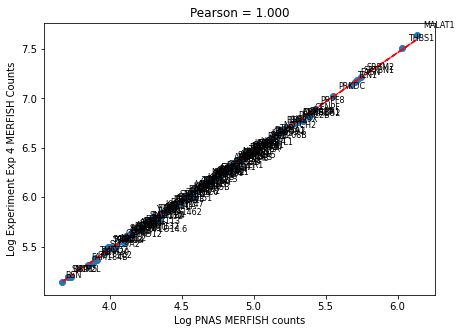

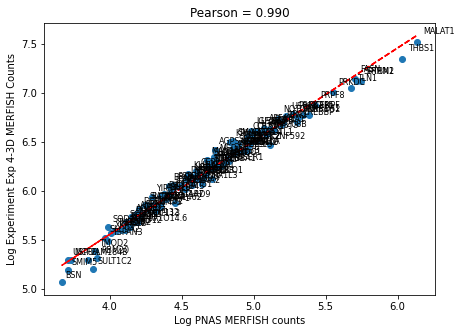

In [58]:
mercounts = {}
for v in range(len(counts_sum_per_gene_all_cells)):
    cts = np.log10(counts_sum_per_gene_all_cells[v])
    for i in range(len(cts)):
        mercounts[genetypes[i]] = float(cts[i])

    plot_correlation(xcounts=merfish_counts2,#pnas_dict_rna,#new_pnas_counts, 
                       ycounts=mercounts, #zcounts=genes_to_consider7,
                       xlabel='Log PNAS MERFISH counts', 
                       ylabel='Log Experiment ' + order[v] + ' MERFISH Counts', 
                       outfile='RNASeq_corr.png',
                       omit=[])

# Relative Expression Rank Comparison

In [42]:
topvals = {}
for i in range(len(mask_folders)):
    mask_folder = mask_folders[i]
    table = pd.read_csv(raw_counts_folders[i])
    
    edgecells = set()
    for fov, filename in enumerate(sorted(glob.glob(os.path.join(mask_folder, '*_cp_masks.png')))):
        mask = np.asarray(PIL.Image.open(filename))
        edgecells.update(10000*fov + np.unique(np.concatenate([mask[:,0], mask[:,-1], mask[0,:], mask[-1,:]])))
    
    table.head()
    table = table[~table['cell_id'].isin(edgecells)] 
    for index, row in table.iterrows():
        total = sum(row[1:])
        for i in range(len(row)):
            if i != 0:
                row[i] = float(row[i]/total)*1000000
    
    ziplist_gene = []
    for k in genetypes:
        pp = table[k].tolist()
        pp = sum(pp)/len(pp)
        ziplist_gene.append(pp)
        
    ziplist_percent = []

    for z in ziplist_gene:
        countt = 0
        for b in ziplist_gene:
            if b > z:
                countt += 1
        ziplist_percent.append(countt/len(ziplist_gene))       
    
    for k in range(len(genetypes)):  
        if genetypes[k] in topvals:   
            topvals[genetypes[k]].append(ziplist_percent[k])
        else:
            topvals[genetypes[k]] = [ziplist_percent[k]]
    

In [ ]:
for gene in topvals:    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(order,topvals.get(gene))
    plt.title('Percent counts higher than ' + gene)
    plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(order,topvals.get('SOD2'))
plt.title('Percent counts higher than SOD2')# + gene)
plt.show()

t-test gel-embedded non-embedded expression rank

In [52]:
import scipy.stats as sst

df = pd.DataFrame([statistics.stdev(topvals.get(n)[0]) for n in topvals])
#df = pd.DataFrame([topvals.get(n)[0] for n in topvals])
df.columns = ['Std Dev']
df.index = [n for n in topvals]
df.sort_values(by = ['Std Dev'], axis = 0)

df13 = pd.DataFrame([statistics.stdev(topvals.get(n)[1]) for n in topvals])
#df13 = pd.DataFrame([topvals.get(n)[1] for n in topvals])
df13.columns = ['Std Dev']
df13.index = [n for n in topvals]
df13=np.sort(df13['Std Dev'])


ttest = sst.ttest_ind(df, df13)
print(ttest)

Ttest_indResult(statistic=array([0.]), pvalue=array([1.]))


# RNAseq Relative Expression Rank

In [53]:

pnas_dict_rna_names = [i for i in pnas_dict_rna]
pnas_dict_rna_values = [pnas_dict_rna.get(i) for i in pnas_dict_rna]
df_rna = pd.DataFrame(zip(pnas_dict_rna_names, pnas_dict_rna_values))
df_rna.columns = ['gene', 'ct']
df_rna = df_rna.sort_values(by=['ct'])
df_rna['higher_than'] = [i for i in range(len(df_rna['gene']))]

df_rna_dict = {}
for i in range(len(df_rna['gene'])):
    df_rna_dict[df_rna['gene'][i]] = df_rna['higher_than'][i]
    
vals = [topvals.get(n)[0] for n in topvals]
genes = [n for n in topvals]
df_rna2 = pd.DataFrame(zip(genes, vals))
df_rna2.columns = ['gene', 'ct']
df_rna2 = df_rna2.sort_values(by=['ct'])
df_rna2['higher_than'] = [(i-129)*-1 for i in range(len(df_rna2['gene']))]

df_mer_dict = {}
for i in range(len(df_rna2['gene'])):
    df_mer_dict[df_rna2['gene'][i]] = df_rna2['higher_than'][i]

In [54]:
def plot_correlation2(xcounts, ycounts, xlabel, ylabel, outfile, omit=[]):
    set1 = set(xcounts.keys())
    set2 = set(ycounts.keys())
    genes_to_consider = list(set1.intersection(set2))
    #genes_to_consider = zcounts
    x = [xcounts[gene] for gene in genes_to_consider if gene not in omit]
    y = [ycounts[gene] for gene in genes_to_consider if gene not in omit]
    using = []
    #using.append("PRPF8")
    #using.append("BRCA2")
    #using.append("MALAT1")
    #using.append("EGFR")
    #using.append("CENPF")
    #using.append("MED14")
    #using.append("CBX5")
    #using.append("SMARCA5")
    #using.append("IGF2R")
    #using.append("FBN2")
    #using.append("THBS1")
    for gene in genes_to_consider: 
        if gene not in omit and gene in using:
            print(gene, (10**ycounts[gene]))
    num = []
    count = 0
    for gene in genes_to_consider:
    #    if gene not in omit:
    #        count += 1
            #print(gene)
    #        if gene == "EGFR":
    #            print(10**y[count])
            if gene not in omit:
                num.append(gene) 
    
    corr, pval = pearsonr(x,y)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.figure(figsize=(7,5))
    plt.plot(x,p(x),"r--")

    plt.scatter(x, y)
    plt.title("Pearson = %.3f" %corr)
    plt.ylabel(ylabel)
    plt.xlim(-5, 135)
    plt.ylim(-5, 135)
    plt.xlabel(xlabel)
    for i, txt in enumerate(num):
        plt.annotate(txt, (x[i], y[i]), size=8)#, textcoords= "figure fraction")
    #plt.savefig(os.path.join(analysis_folder, outfile), dpi=300)
    

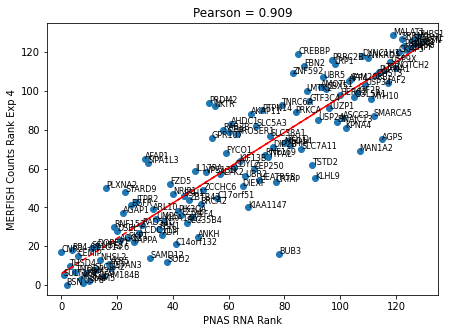

In [55]:
plot_correlation2(xcounts=df_rna_dict,#pnas_dict_rna,#new_pnas_counts, 
                    ycounts=df_mer_dict, #zcounts=genes_to_consider7,
                    xlabel='PNAS RNA Rank', 
                    ylabel='MERFISH Counts Rank Exp 4', 
                    outfile='RNASeq_corr.png',
                    omit=[])

# Find 2 bit similarities

Enter gene name below

In [ ]:
gene2bit = "SOD2"
codebook = pandas.read_csv(codebook_file)
codebook2 = codebook[~codebook['name'].str.contains("blank")]
codebook2 = codebook2[~codebook2['name'].str.contains("notarget")]
codebook_dict = {}
for index, codebook2r in codebook2.iterrows():

    addlist = [codebook2r.bit1, codebook2r.bit2, codebook2r.bit3, codebook2r.bit4, codebook2r.bit5, codebook2r.bit6, codebook2r.bit7, codebook2r.bit8, codebook2r.bit9, codebook2r.bit10, codebook2r.bit11, codebook2r.bit12, codebook2r.bit13, codebook2r.bit14, codebook2r.bit15, codebook2r.bit16]
    codebook_dict[codebook2r.id] = addlist

spots = [i+1 for i in range(len(codebook_dict.get(gene2bit))) if codebook_dict.get(gene2bit)[i] == 1]
spots

In [ ]:
code_id = codebook2['id'].tolist()
genes_the_same = []
bits_the_same = []
for ij in code_id:
    if ij == gene2bit:
        continue
    else:
        spots_compare = [i for i in range(len(codebook_dict.get(ij))) if codebook_dict.get(ij)[i] == 1]
        spots_compare = [k+1 for k in spots_compare if k+1 in spots]

        if len(spots_compare) >= 2:
            genes_the_same.append(ij)
            bits_the_same.append([e for e in spots_compare])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(order,topvals.get(gene2bit))
plt.title('Percent counts higher than ' + gene2bit)# + gene)
plt.show()

Viewing specific similar bits as outputted 2 cells above

In [ ]:
bcount = 0
#enter the gene bits you want to look at i.e [1, 7]
bits_included = [16]
for f in genes_the_same:
    if len([i for i in bits_included if i in bits_the_same[bcount]]) == len(bits_included):
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        ax.bar(order,topvals.get(f))
        plt.title('Percent counts higher than ' + f + ', Bits: ' + str(bits_the_same[bcount]))# + gene)
        plt.show()
    bcount += 1

# Find total experiment statistics by looking at the raw counts for all genes at once per cell

In [ ]:
import glob
import os
import pandas as pd
import numpy as np
from PIL import Image
#mask_folder = r'D:\MERFISH\Segmentation\E20190919_R0003\cy3_320diameter_slice30'
#mask_folder = r'D:\MERFISH\Segmentation\E20190920_R0004\cyto_fullsize_320diameter'
#mask_folder = r'D:\MERFISH\Segmentation\E20190930_R0006\cy3_320diameter_slice30'
#mask_folder = r'D:\MERFISH\Segmentation\E20201106_R0034\cyto_fullsize_320diameter'
#mask_folder = r'D:\MERFISH\Segmentation\E20201222_R0049_S1\cyto_fullsize_320diameter'
#mask_folder = r'D:\MERFISH\Segmentation\E20201123_R0040\cyto_fullsize'
mask_folder = r'D:\MERFISH\Segmentation\E20201106_R0035\cyto_fullsize_320diameter'

edgecells = set()
for fov, filename in enumerate(sorted(glob.glob(os.path.join(mask_folder, '*_cp_masks.png')))):
    mask = np.asarray(PIL.Image.open(filename))
    edgecells.update(10000*fov + np.unique(np.concatenate([mask[:,0], mask[:,-1], mask[0,:], mask[-1,:]])))
#table = pd.read_csv("D:\MERFISH\MERlin_Analysis\E20201106_R0034\single_cell_raw_counts.csv")
#table = pd.read_csv("D:\MERFISH\Archived_Experiments\E20190919_R0003\MERlin_Analysis\E20190919_R0003_v2\single_cell_raw_counts.csv")
#table = pd.read_csv("D:\MERFISH\E20190920_R0004\MERlin_Analysis\E20190920_R0004_v4\single_cell_analysis_cyto_fullsize_320diameter\single_cell_raw_counts.csv")
#table = pd.read_csv("D:\MERFISH\Archived_Experiments\E20190930_R0006\MERlin_Analysis\E20190930_R0006\single_cell_raw_counts.csv")
table = pd.read_csv("D:\MERFISH\MERlin_Analysis\E20201106_R0035\single_cell_raw_counts.csv")
#table = pd.read_csv("D:\MERFISH\MERlin_Analysis\E20201223_R0049_S2\single_cell_analysis_cyto_fullsize_320diameter\single_cell_raw_counts.csv")
#table = pd.read_csv("D:\MERFISH\MERlin_Analysis\E20201222_R0049_S1\single_cell_raw_counts.csv")
#table = pd.read_csv("D:\MERFISH\MERlin_Analysis\E20201123_R0040\single_cell_raw_counts.csv")
table = table[~table['cell_id'].isin(edgecells)] 
#for index, row in table.iterrows():
#    total = sum(row[1:])
#    for i in range(len(row)):
#        if i != 0:
#            row[i] = float(row[i]/total)*1000000
import statistics 

table["TotalVals"] = table[list(table.columns)].sum(axis=1)
total_vals = table["TotalVals"].to_list()
average_per_cell = sum(total_vals)/len(total_vals)
num_cells = len(total_vals)
std_dev_cell = statistics.stdev(total_vals)

print(sum(total_vals))
#print(sum(prp_vals))
print(num_cells)
print(average_per_cell)
print(std_dev_cell)
print(std_dev_cell/average_per_cell)
import numpy as np
import pandas as pd
import matplotlib
histo = pd.DataFrame({'Experiment 40 Counts Per Cell': total_vals})
binwidth = max(total_vals)/40
plot = histo.plot.hist( bins=np.arange(min(total_vals), max(total_vals) + binwidth, binwidth))
fig = plot.get_figure()        

# Spatial

In [54]:
fov_positions = pd.read_csv("D:\MERFISH\E20200310_R0022\MERlin_Analysis\E20200310_R0022\positions.csv", header = None)
barcode_positions = pd.read_csv("D:/MERFISH/E20200310_R0022/MERlin_Analysis/E20200310_R0022/ExportBarcodes/barcodes.csv")

In [55]:
fov_positions = fov_positions.reset_index()

In [56]:
fov_positions.columns = ['fov', 'x', 'y']

Showing the barcode density at different positions

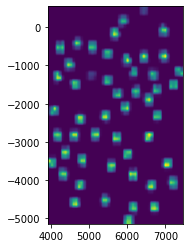

In [58]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt

x =  barcode_positions['global_x'].tolist()
y = barcode_positions['global_y'].tolist()

heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)#, range = [[-1500, 2000], [-1500, 1500]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

In [50]:
import glob
import os
import numpy as np
import PIL
from tqdm import tqdm
from PIL import Image
#mask_folder = r'D:\MERFISH\Segmentation\E20190920_R0004\cyto_fullsize_320diameter'
nuclei_folder = r'D:\MERFISH\Segmentation\E20200310_R0022\22_nuclei_slice32'
cell_folder = r'D:\MERFISH\Segmentation\E20200310_R0022\cy3_320diameter_slice30_second'

def load_segmentation(segmask_dir, type='png'):
    segm = []
    cell_count = 0
    print("Loading segmentation masks...")
    if (type=='png'):
        for file in tqdm(glob.glob(os.path.join(segmask_dir, "*_cp_masks.png"))):
            segm.append(np.asarray(Image.open(file)))
            cell_count += np.max(segm[-1])
    elif (type=='npy'):
        for file in tqdm(glob.glob(os.path.join(segmask_dir, "*_seg.npy"))):
            segm.append(np.load(file,allow_pickle=True))
            cell_count += np.max(segm[-1])
    else:
        print("Type must be either 'png' or 'npy'")
    print(cell_count, "cells found")
    return segm

segcell = load_segmentation(cell_folder)
segnuclei = load_segmentation(nuclei_folder)

Loading segmentation masks...


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.68it/s]


1372 cells found
Loading segmentation masks...


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.76it/s]


1299 cells found


In [51]:
import pandas as pd
def cell_metadata_table(segm):
    """Create a metadata table for cells.
    
    Input -- A list of cell segmentation masks
    Output -- A pandas table with a colume 'volume' and index of cell id.
    """
    cell_ids = []
    volumes = []
    for fov, seg in enumerate(segm):
        unique, counts = np.unique(seg, return_counts=True)
        for cell_id, volume in zip(unique, counts):
            if cell_id == 0:
                continue
            cell_ids.append(fov*10000 + cell_id)
            volumes.append(volume)
    celldata = pd.DataFrame(volumes, index=cell_ids, columns=['volume'])
    return celldata
segcell_table = cell_metadata_table(segcell)
segnuclei_table = cell_metadata_table(segnuclei)

In [52]:
def filter_cells_by_volume(celldata, min_volume, max_sigma):
    #Remove small cells
    start = len(celldata.index)
    celldata = celldata.drop(celldata[celldata['volume'] < min_volume].index)
    print(f"Dropped {start-len(celldata.index)} cells with volume < 50 pixels")

    #Remove large cells
    start = len(celldata.index)
    median = np.median(celldata['volume'])
    celldata = celldata.drop(celldata[celldata['volume'] > median*max_sigma].index)
    print(f"Dropped {start-len(celldata.index)} cells with volume > {median*max_sigma} pixels")
    return celldata

segcell_table = filter_cells_by_volume(segcell_table, 50, 3)
segnuclei_table = filter_cells_by_volume(segnuclei_table, 50, 3)

Dropped 0 cells with volume < 50 pixels
Dropped 1 cells with volume > 127866.0 pixels
Dropped 0 cells with volume < 50 pixels
Dropped 0 cells with volume > 103785.0 pixels


In [84]:
cel_table = 0
nuc_table = 0
def assign_barcodes_to_cells_and_nuclei(data, segm, segm_nuc, celldata):
    
    def get_cell_id(row):
        x = int(row['x'])
        y = int(row['y'])
        fov = int(row['fov'])
        if segm[fov][y, x] == 0:
            return 0
        elif segm_nuc[fov][y, x] == 0:
            return 10000*fov + segm[fov][y, x] 
        else:
            return 10000*fov + segm[fov][y, x] + 1000000

    data['cell_id'] = data.apply(get_cell_id, axis=1) 


    in_cells = len(data[data['cell_id'] != 0])
    in_nuclei = len(data[data['cell_id'] >= 1000000])
    print(f"{in_cells} ({100*in_cells/len(data):0.2f}%) barcodes assigned to cells")
    print(f"{in_nuclei} ({100*in_nuclei/len(data):0.2f}%) barcodes assigned to cells in nuclei")

    #Drop barcodes not assigned to cells
    data = data[data['cell_id'] != 0]
    #Drop barcodes in cells that were pruned
    datanuc = data[(data['cell_id'] - 1000000).isin(celldata.index)]
   # data_nuc['nucleus_id'] = data_nuc.apply(get_nucleus_id, axis=1)
    data = data[data['cell_id'].isin(celldata.index)]

    datanuc.to_csv("D:/MERFISH/E20200310_R0022/MERlin_Analysis/E20200310_R0022/nuc_barcodes_counts.csv")
    data.to_csv("D:/MERFISH/E20200310_R0022/MERlin_Analysis/E20200310_R0022/cell_barcodes_counts.csv")
    
    #Create cell by gene table
    ctable = pd.crosstab(index=data.cell_id, columns=data.barcode_id)
    ctable_nuc = pd.crosstab(index=datanuc.cell_id, columns=datanuc.barcode_id)
    
    cel_table = ctable
    nuc_table = ctable_nuc
    #Rename barcode ids to gene names
    codebook = pd.read_csv(codebook_file)
    ctable = ctable.rename(columns=lambda n: codebook.loc[n]['name'])
    ctable_nuc = ctable_nuc.rename(columns=lambda n: codebook.loc[n]['name'])
    #Drop notarget barcodes
    drop_cols = [col for col in ctable.columns if 'notarget' in col]
    drop_cols_nuc = [col for col in ctable_nuc.columns if 'notarget' in col]
    ctable = ctable.drop(columns=drop_cols)
    ctable_nuc = ctable_nuc.drop(columns=drop_cols_nuc)
    return ctable, ctable_nuc
cel_table, nuc_table = assign_barcodes_to_cells_and_nuclei(barcode_positions, segcell, segnuclei, segcell_table)

17874193 (58.80%) barcodes assigned to cells
13711199 (45.11%) barcodes assigned to cells in nuclei


In [72]:
cel_table.to_csv("D:/MERFISH/E20200310_R0022/MERlin_Analysis/E20200310_R0022/cell_table_spatial.csv")
nuc_table.to_csv("D:/MERFISH/E20200310_R0022/MERlin_Analysis/E20200310_R0022/nuc_table_spatial.csv")

# inside nuclei rna expression

In [76]:

import glob
import os
import pandas as pd
import numpy as np
import PIL
from PIL import Image


mask_folder = r'D:\MERFISH\Segmentation\E20200310_R0022\22_nuclei_slice32'


#read in segmentation mask
edgecells = set()
for fov, filename in enumerate(sorted(glob.glob(os.path.join(mask_folder, '*_cp_masks.png')))):
    mask = np.asarray(PIL.Image.open(filename))
    edgecells.update(10000*fov + np.unique(np.concatenate([mask[:,0], mask[:,-1], mask[0,:], mask[-1,:]])) + 1000000)
    
table = pd.read_csv("D:/MERFISH/E20200310_R0022/MERlin_Analysis/E20200310_R0022/nuc_table_spatial.csv")
#filter out the cells on the edges
table = table[~table['cell_id'].isin(edgecells)] 
for index, row in table.iterrows():
    total = sum(row[1:])
    for i in range(len(row)):
        if i != 0:
            row[i] = float(row[i]/total)*1000000
        

15035544
1001
15020.523476523476
7782.783440755518
0.5181432892748193


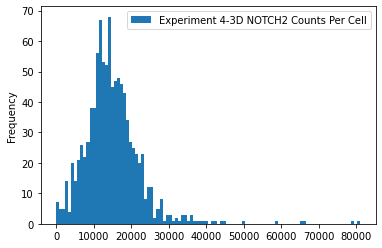

In [77]:
import statistics
import numpy as np
import pandas as pd
import matplotlib
#Get the specific gene from the table and perform calculations
prp_vals = table["NOTCH2"].to_list()
average_per_cell = sum(prp_vals)/len(prp_vals)
num_cells = len(prp_vals)
std_dev_cell = statistics.stdev(prp_vals)

#The total number of gene counts across all cells
print(sum(prp_vals))
#The total number of cells after filtering in the experiment
print(num_cells)
#The average number of gene counts per cell
print(average_per_cell)
#The standard deviation of the number of gene counts per cell
print(std_dev_cell)
#The standard deviation of the number of gene counts per cell divided by the average number of gene counts per cell
print(std_dev_cell/average_per_cell)

histo = pd.DataFrame({'Experiment 4-3D NOTCH2 Counts Per Cell': table["NOTCH2"].to_list()})
plot = histo.plot.hist(bins = 100)
fig = plot.get_figure()

In [79]:
new_pnas = pd.read_csv(r'D:\MERFISH\Random_Data\PNAS2016_MERFISH_counts_new.csv', sep=',', header = None)
new_pnas.columns = ['name', 'counts'] 

new_pnas_counts = dict(zip(new_pnas['name'], np.log10(new_pnas['counts']+1)))

counts_sum_per_gene_all_cells = []
gene_average_counts_per_cell = []
std_deviation_per_gene = []
divided_per_gene = []
num_cells_exp = []
#order = ['Exp 3', 'Exp 4', 'Exp 6', 'Exp 34', 'Exp 49_S1', 'Exp 40', 'Exp 22', 'Exp 49_S2']
order = ['Exp 22']
mask_folders = ['D:\MERFISH\Segmentation\E20200310_R0022\22_nuclei_slice32']
raw_counts_folders = ["D:/MERFISH/E20200310_R0022/MERlin_Analysis/E20200310_R0022/nuc_table_spatial.csv"]
genetypes = table.columns[1:]
for i in range(len(mask_folders)):
    mask_folder = mask_folders[i]
    table = pd.read_csv(raw_counts_folders[i])
    
    edgecells = set()
    for fov, filename in enumerate(sorted(glob.glob(os.path.join(mask_folder, '*_cp_masks.png')))):
        mask = np.asarray(PIL.Image.open(filename))
        edgecells.update(10000*fov + np.unique(np.concatenate([mask[:,0], mask[:,-1], mask[0,:], mask[-1,:]])))
    
    table.head()
    table = table[~table['cell_id'].isin(edgecells)] 
    for index, row in table.iterrows():
        total = sum(row[1:])
        for i in range(len(row)):
            if i != 0:
                row[i] = float(row[i]/total)*1000000
        
    prpvals_list = []
    average_per_cell_list = []
    num_cells_list = []
    std_list = []
    divided_list = []
    for i in genetypes:
    #for i in genetypes:
        prp_vals = table[i].to_list()
        average_per_cell = sum(prp_vals)/len(prp_vals)
        num_cells = len(prp_vals)
        std_dev_cell = statistics.stdev(prp_vals)
        prpvals_list.append(sum(prp_vals))
        average_per_cell_list.append(average_per_cell)
        num_cells_list.append(num_cells)
        std_list.append(std_dev_cell)
        divided_list.append(std_dev_cell/average_per_cell)
    counts_sum_per_gene_all_cells.append(prpvals_list)
    gene_average_counts_per_cell.append(average_per_cell_list)
    std_deviation_per_gene.append(std_list)
    divided_per_gene.append(divided_list)
    num_cells_exp.append(num_cells)

In [81]:
import math
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def plot_correlation(xcounts, ycounts, xlabel, ylabel, outfile, omit=[]):
    set1 = set(xcounts.keys())
    set2 = set(ycounts.keys())
    genes_to_consider = list(set1.intersection(set2))
    x = [xcounts[gene] for gene in genes_to_consider if gene not in omit]
    y = [ycounts[gene] for gene in genes_to_consider if gene not in omit]
    using = []
    #using.append("PRPF8")

    for gene in genes_to_consider: 
        if gene not in omit and gene in using:
            print(gene, (10**ycounts[gene]))
    num = []
    count = 0
    for gene in genes_to_consider:
    #    if gene not in omit:
    #        count += 1
            #print(gene)
    #        if gene == "EGFR":
    #            print(10**y[count])
            if gene not in omit:
                num.append(gene) 
    
    corr, pval = pearsonr(x,y)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.figure(figsize=(7,5))
    plt.plot(x,p(x),"r--")

    plt.scatter(x, y)
    plt.title("Pearson = %.3f" %corr)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    for i, txt in enumerate(num):
        plt.annotate(txt, (x[i], y[i]), size=8, textcoords="offset points")
    #plt.savefig(os.path.join(analysis_folder, outfile), dpi=300)
    

C:\Users\amonell\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


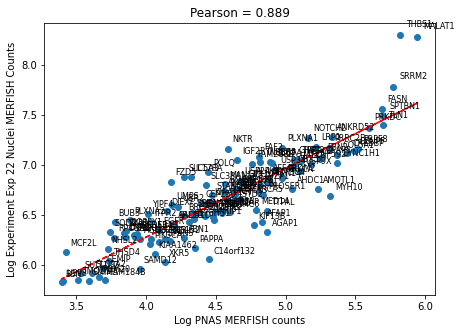

In [83]:
mercounts = {}
for v in range(len(counts_sum_per_gene_all_cells)):
    cts = np.log10(counts_sum_per_gene_all_cells[v])
    for i in range(len(cts)):
        mercounts[genetypes[i]] = float(cts[i])

    plot_correlation(xcounts=new_pnas_counts,#pnas_dict_rna,#new_pnas_counts, 
                       ycounts=mercounts, #zcounts=genes_to_consider7,
                       xlabel='Log PNAS MERFISH counts', 
                       ylabel='Log Experiment ' + order[v] + ' Nuclei MERFISH Counts', 
                       outfile='RNASeq_corr.png',
                       omit=[])

# spatial nucleus count

In [85]:
nuc = pd.read_csv("D:/MERFISH/E20200310_R0022/MERlin_Analysis/E20200310_R0022/nuc_barcodes_counts.csv")
nuc_cellid = nuc['cell_id'].to_list()
nuc_cellid = [i - 1000000 for i in nuc_cellid]
nuc['cell_id'] = nuc_cellid
cel = pd.read_csv("D:/MERFISH/E20200310_R0022/MERlin_Analysis/E20200310_R0022/cell_barcodes_counts.csv")
nuc = nuc[['barcode_id', 'global_x', 'global_y', 'global_z', 'x', 'y', 'fov', 'cell_id']]
cel = cel[['barcode_id', 'global_x', 'global_y', 'global_z', 'x', 'y', 'fov', 'cell_id']]
nuc.columns = ['barcode_id', 'global_x', 'global_y', 'global_z', 'x', 'y', 'fov', 'cell_id_nuc']

In [103]:
len(nuc)

13697045

In [104]:
nuc.head()

,barcode_id,global_x,global_y,global_z,x,y,fov,cell_id_nuc
0,6,6844.230,-2345.4304,0.0,1665.55700,764.99603,0,12
1,6,6690.748,-2258.2683,0.0,244.42569,1572.05270,0,25
2,6,6749.733,-2226.0095,0.0,790.58040,1870.74570,0,30
3,7,6830.390,-2327.3071,0.0,1537.40900,932.80450,0,16
4,7,6869.409,-2293.3525,0.0,1898.69780,1247.19760,0,21


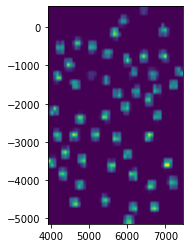

In [105]:
x =  nuc['global_x'].tolist()
y = nuc['global_y'].tolist()

heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)#, range = [[-1500, 2000], [-1500, 1500]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()
#nucleus concentrated

# Get Nucleus Statistics

In [188]:
mask_folder = r'D:\MERFISH\Segmentation\E20200310_R0022\cy3_320diameter_slice30_second'

tablenuc = pd.read_csv("D:/MERFISH/E20200310_R0022/MERlin_Analysis/E20200310_R0022/nuc_table_spatial.csv")

tablecell = pd.read_csv("D:/MERFISH/E20200310_R0022/MERlin_Analysis/E20200310_R0022/cell_table_spatial.csv")


In [189]:
tablenuc['cell_id'] = tablenuc['cell_id'] - 1000000
tablecell = pd.merge(tablecell, tablenuc, how = 'outer',on = ['cell_id'])
tablecell_pseudo = tablecell.fillna(0.0)

In [190]:
for i in tablecell_pseudo.columns:
    if i[-1] == 'x':
        col = i.split('_')[0] + '_y'
        tablecell_pseudo[i.split('_')[0] + '_total'] = tablecell_pseudo[i.split('_')[0] + '_x'] + tablecell_pseudo[i.split('_')[0] + '_y']

In [192]:
for i in tablecell_pseudo.columns:
    if i[-1] == 'y':
        tablecell_pseudo[i.split('_')[0] + '_nucPercentage'] = tablecell_pseudo[i.split('_')[0] + '_y'] / tablecell_pseudo[i.split('_')[0] + '_total']

In [200]:
tablecell_pseudo['sum_nucs'] = [0.0 for i in range(len(tablecell_pseudo['cell_id'].tolist()))]
for i in tablecell_pseudo.columns:
    if i[-1] == 'y':
        tablecell_pseudo['sum_nucs'] = tablecell_pseudo['sum_nucs'] + tablecell_pseudo[i]

In [201]:
tablecell_pseudo['sum_all'] = [0.0 for i in range(len(tablecell_pseudo['cell_id'].tolist()))]
for i in tablecell_pseudo.columns:
    if i[-1] == 'x' or i[-1] == 'y':
        tablecell_pseudo['sum_all'] = tablecell_pseudo['sum_all'] + tablecell_pseudo[i]

In [202]:
genecount = 0
for i in tablecell_pseudo.columns:
    if i[-1] == 'y':
        genecount += 1

In [203]:
tablecell_pseudo['average_nucs'] = tablecell_pseudo['sum_nucs'] / tablecell_pseudo['sum_all']

In [205]:
cel.columns = ['barcode_id', 'global_x', 'global_y', 'global_z', 'x', 'y', 'fov', 'cell_id_nuc']
cel_nuc = pd.concat([cel, nuc])
tomerge = tablecell_pseudo[['cell_id', 'average_nucs']]
cel_nuc.columns = ['barcode_id', 'global_x', 'global_y', 'global_z', 'x', 'y', 'fov', 'cell_id']
cel_nuc = pd.merge(cel_nuc, tomerge, on = ['cell_id'])

# Visualize Nucleus RNA total concentration in an fov

In [213]:
fov_nuc = cel_nuc[cel_nuc['fov'] == 0]

In [214]:
x_g = fov_nuc['global_x'].tolist()
y_g = fov_nuc['global_y'].tolist()
color = fov_nuc['average_nucs'].tolist()

plt.scatter(x_g, y_g, c=color, cmap='viridis')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

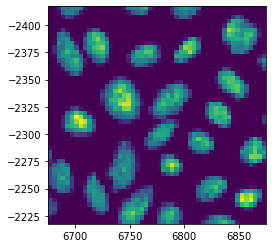

In [218]:
x_n =  fov_nuc['global_x'].tolist()
y_n = fov_nuc['global_y'].tolist()

heatmap, xedges, yedges = np.histogram2d(x_n, y_n, bins=50)#, range = [[-1500, 2000], [-1500, 1500]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()

plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.gca().invert_yaxis()
plt.show()
#barcode concentration

# Visualize Nucleus Specific RNA concentration in an fov

In [239]:
#set everything
genes_nuclear_loc = ['CBX5']

cel = pd.read_csv("D:/MERFISH/E20200310_R0022/MERlin_Analysis/E20200310_R0022/cell_barcodes_counts.csv")
nuc = pd.read_csv("D:/MERFISH/E20200310_R0022/MERlin_Analysis/E20200310_R0022/nuc_barcodes_counts.csv")
nuc_cellid = nuc['cell_id'].to_list()
nuc_cellid = [i - 1000000 for i in nuc_cellid]
nuc['cell_id'] = nuc_cellid

nuc = nuc[['barcode_id', 'global_x', 'global_y', 'global_z', 'x', 'y', 'fov', 'cell_id']]
cel = cel[['barcode_id', 'global_x', 'global_y', 'global_z', 'x', 'y', 'fov', 'cell_id']]
nuc.columns = ['barcode_id', 'global_x', 'global_y', 'global_z', 'x', 'y', 'fov', 'cell_id_nuc']

cel.columns = ['barcode_id', 'global_x', 'global_y', 'global_z', 'x', 'y', 'fov', 'cell_id_nuc']
cel_nuc = pd.concat([cel, nuc])
cel_nuc.columns = ['barcode_id', 'global_x', 'global_y', 'global_z', 'x', 'y', 'fov', 'cell_id']

specific = [0.0 for i in range(len(tablecell_pseudo['cell_id'].tolist()))]
for i in tablecell_pseudo.columns:
    if i[-1] == 'y' and len([k for k in genes_nuclear_loc if k in i]) > 0:
        specific = specific + tablecell_pseudo[i]
        
specific_all = [0.0 for i in range(len(tablecell_pseudo['cell_id'].tolist()))]
for i in tablecell_pseudo.columns:
    if i[-1] == 'x' or i[-1] == 'y' and len([k for k in genes_nuclear_loc if k in i]) > 0:
        specific_all = specific_all + tablecell_pseudo[i]

average_all = specific / specific_all

tomergerna = tablecell_pseudo[['cell_id']]
tomergerna['average_nucs'] = average_all
cel_nuc2 = pd.merge(cel_nuc, tomergerna, on = ['cell_id'])




C:\Users\amonell\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


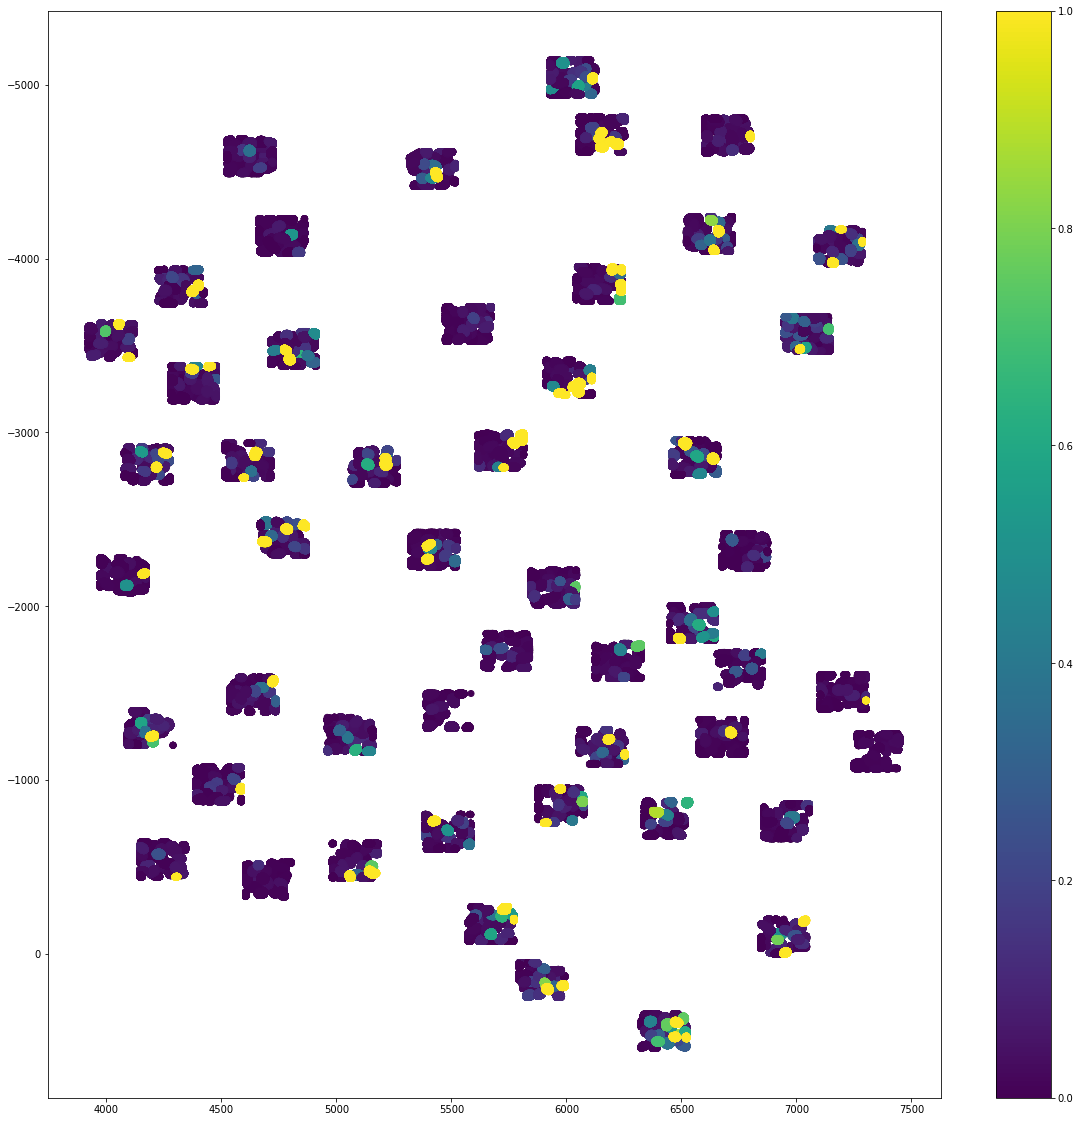

In [247]:
fov_nuc2 = cel_nuc2#[cel_nuc2['fov'].isin([k for k in range(10)])]
x_g = fov_nuc2['global_x'].tolist()
y_g = fov_nuc2['global_y'].tolist()
color = fov_nuc2['average_nucs'].tolist()

plt.rcParams["figure.figsize"] = (20,20)
plt.scatter(x_g, y_g, c=color, cmap='viridis')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

# all genes plots at once

In [235]:
genelister = []
for i in tablecell_pseudo.columns:
    if i[-1] == 'y':
        genelister.append(i.split('_')[0])

In [ ]:
fovnum = [0]
for g in genelister:    
    #set everything
    genes_nuclear_loc = [g]

    cel_nuc = pd.concat([cel, nuc])
    cel_nuc.columns = ['barcode_id', 'global_x', 'global_y', 'global_z', 'x', 'y', 'fov', 'cell_id']

    specific = [0.0 for i in range(len(tablecell_pseudo['cell_id'].tolist()))]
    for i in tablecell_pseudo.columns:
        if i[-1] == 'y' and len([k for k in genes_nuclear_loc if k in i]) > 0:
            specific = specific + tablecell_pseudo[i]

    specific_all = [0.0 for i in range(len(tablecell_pseudo['cell_id'].tolist()))]
    for i in tablecell_pseudo.columns:
        if i[-1] == 'x' or i[-1] == 'y' and len([k for k in genes_nuclear_loc if k in i]) > 0:
            specific_all = specific_all + tablecell_pseudo[i]

    average_all = specific / specific_all

    tomergerna = tablecell_pseudo[['cell_id']]
    tomergerna['average_nucs'] = average_all
    cel_nuc2 = pd.merge(cel_nuc, tomergerna, on = ['cell_id'])
    
    fov_nuc2 = cel_nuc2[cel_nuc2['fov'].isin(fovnum)]
    x_g = fov_nuc2['global_x'].tolist()
    y_g = fov_nuc2['global_y'].tolist()
    color = fov_nuc2['average_nucs'].tolist()

    plt.scatter(x_g, y_g, c=color, cmap='viridis')
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.title(g + ' Nucleus Spatial')
    plt.show()

# Spatial Total

In [327]:
transcript = ['CKAP5']

In [328]:
for i in tablecell_pseudo.columns:
    if i[-1] == 'x':
        col = i.split('_')[0] + '_y'
        tablecell_pseudo[i.split('_')[0] + '_q'] = tablecell_pseudo[i.split('_')[0] + '_x'] + tablecell_pseudo[i.split('_')[0] + '_y']

In [329]:
liscol = []
for i in tablecell_pseudo.columns:
    if i[-1] == 'q':
        liscol.append(i)
table_cell_q = tablecell_pseudo[liscol]

In [330]:

for index, row in table_cell_q.iterrows():
    total = sum(row[:])
    for i in range(len(row)):
        row[i] = float(row[i]/total)*1000000

In [331]:
table_cell_q['cell_id'] = tablecell_pseudo['cell_id']

C:\Users\amonell\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [332]:
cel_nucdata = 0
for i in transcript:
    for j in table_cell_q.columns:
        coll = ''
        if j.split('_q')[0] == i:
            coll = j
    
            datacell = pd.DataFrame(zip(table_cell_q[coll].tolist(), table_cell_q['cell_id'].tolist()))
            datacell.columns = ['counts', 'cell_id']
            cel_nucdata = pd.merge(cel_nuc, datacell, on = ['cell_id'])
        

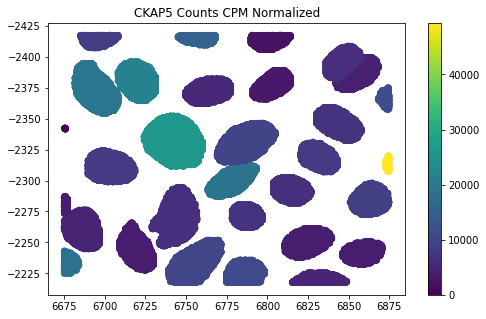

In [333]:
fov_nuc2 = cel_nucdata[cel_nucdata['fov'].isin([0])]
x_g = fov_nuc2['global_x'].tolist()
y_g = fov_nuc2['global_y'].tolist()
color = fov_nuc2['counts'].tolist()

plt.rcParams["figure.figsize"] = (8,5)
plt.scatter(x_g, y_g, c=color, cmap='viridis')
plt.gca().invert_yaxis()
plt.title(transcript[0] + ' Counts CPM Normalized')
plt.colorbar()
plt.show()